A notebook demostrating the use of Archie's Law to estimate water qulity estimates. The equation is the following.

logCw = logCt – mlogØ

 

where Cw is the predicted fluid EC (S/m), Ct is bulk conductivity and logØ is the free water.

We are trying to estimate fluid EC at on a grid given AEM conductivity (interpolated) and mobile water (interpolated) and a cementation factor based on empirical relationships developed using pore fluid EC and borehole NMR.

Neil Symington
neil.symington@ga.gov.au

In [173]:
%matplotlib inline

In [174]:
import pandas
import rasterio
import numpy as np
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import netCDF4
import math
import os, glob
import gc
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling

In [188]:
def resample_raster2array(infile, newaff, new_shape, driver='GTiff',
                    null = -999):

    # Open
    src = rasterio.open(infile)

    # Extract data as an array
    arr = src.read()[0]

    # Get the affine
    aff = src.transform


    # Create new array with the grid
    # coordinates from the kriging
    newarr = np.empty(shape=new_shape)

    # Reproject
    reproject(
        arr, newarr,
        src_transform=aff,
        dst_transform=newaff,
        src_crs=src.crs,
        dst_crs=src.crs,
        resampling=Resampling.bilinear)

    src.close()

    # Do some post processing
    #newarr[np.abs(newarr - null) < 0.000001] = np.nan
    newarr[newarr < -10**2] = np.nan

    return newarr

In [177]:
# We also want to reshape the mobile water raster

#infile = r"D:\GA\aquifer_properties\interpolated\cenozoic_mobile.tif"
infile = r"D:\GA\aquifer_properties\interpolated\permocarb_mobile.tif"

mob_water_src = rasterio.open(infile)

In [178]:
arr = mob_water_src.read()[0]

# Get the affine
aff = mob_water_src.transform

# GEt log of the water content

logMob = np.log10(arr)

In [179]:
arr.shape

(251, 261)

In [180]:
# OPen an AEM grid, resample them onto the same affine as the stratigraphy
# and save them as a multiband array

import glob

os.chdir(r"D:\GA\EK_AEM\OrdKeep_borehole_constrained\gdal_grids\grids\layergrids")

arrs = np.empty(shape = (30, arr.shape[0], arr.shape[1]), dtype = np.float32)
intervals = np.zeros(shape = (30,2), dtype = np.float32)

for i, file in enumerate(glob.glob('*.tif')):
    
    print(file)
    
    arrs[i] = resample_raster2array(file, aff, arr.shape,
                                    driver='GTiff', null = 0)
    
    intervals[i] = [float(file.split('_')[2]), float(file.split('_')[3])]

layer_01_000.0_002.0_m.tif
layer_02_002.0_004.0_m.tif
layer_03_004.0_006.2_m.tif
layer_04_006.2_008.4_m.tif
layer_05_008.4_010.9_m.tif
layer_06_010.9_013.6_m.tif
layer_07_013.6_016.6_m.tif
layer_08_016.6_020.0_m.tif
layer_09_020.0_023.8_m.tif
layer_10_023.8_028.1_m.tif
layer_11_028.1_033.1_m.tif
layer_12_033.1_038.8_m.tif
layer_13_038.8_045.3_m.tif
layer_14_045.3_052.9_m.tif
layer_15_052.9_061.6_m.tif
layer_16_061.6_071.7_m.tif
layer_17_071.7_083.4_m.tif
layer_18_083.4_096.9_m.tif
layer_19_096.9_112.6_m.tif
layer_20_112.6_130.8_m.tif
layer_21_130.8_151.9_m.tif
layer_22_151.9_176.3_m.tif
layer_23_176.3_204.7_m.tif
layer_24_204.7_237.6_m.tif
layer_25_237.6_275.7_m.tif
layer_26_275.7_319.9_m.tif
layer_27_319.9_371.3_m.tif
layer_28_371.3_430.9_m.tif
layer_29_430.9_500.0_m.tif
layer_30_500.0_Inf_m.tif


In [181]:
# Create the log conductivity array

logcond =np.log10(arrs)

# GEt depth top array
depth_top = intervals[:,0]

In [143]:
outfile = r"C:\temp\AEM_multiband_downsampled.tif"

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height=arrs.shape[1], width=arrs.shape[2],
                                count=arrs.shape[0], dtype=np.float32,
                                crs=src.crs, transform=aff)
for i in range(30):
    new_dataset.write(arrs[i], i+1)

new_dataset.close()

In [189]:
# Open
#infile = r"D:\GA\KeepWaterTable\raster_elevation_interpolation\nulled\KeepRiver_water_table_mBGL.tif"
infile = r"D:\GA\AEM_interp_OrdKeep\Neil\elevatoin\Cuk_Pk_top.tif"

strat_top = resample_raster2array(infile, aff, arr.shape,
                                    driver='GTiff', null = -3.40282e+38)

#infile = r"D:\GA\AEM_interp_OrdKeep\Neil\elevatoin\Cz_base.tif"
infile = r"D:\GA\AEM_interp_OrdKeep\Neil\elevatoin\Cuk_Pk_base.tif"

strat_base = resample_raster2array(infile, aff, arr.shape,
                                    driver='GTiff', null = null
                                      )


In [196]:
np.nanmax(strat_top)

150.00000000000003

In [191]:
# We need to conver the strat top and base to depth

# Bring in the LiDAR

infile = r"D:\GA\rasters\EK_LiDAR_cubic_5x5.tif"

lid5m = resample_raster2array(infile, aff, arr.shape,
                                    driver='GTiff', null = null
                                      )

In [194]:
# Now convert strat top and base to depth by subtracting them from the LiDAR

strat_top_depth = strat_top
strat_top_depth = lid5m - strat_top
strat_base_depth = lid5m - strat_base

In [210]:
# Do some post processing for negative depths

strat_top_depth[strat_top_depth < 0] = 0

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [232]:
# Now we want to iterate through the strat coordinates
# find top and bottom and use this to find the AEM conductivity

log_AEM_interval = np.nan*np.ones(shape = (strat_top_depth.shape), dtype = np.float32)

for i in range(strat_top_depth.shape[0]):
    for j in range(strat_top_depth.shape[1]):
        top = strat_top_depth[i,j]
        base = strat_base_depth[i,j]
        
        #if (~np.isnan(top)) and (~np.isnan(base)) and (top < base):
        if (~np.isnan(top)) and (top < base):
            top_ind = np.searchsorted(depth_top, top)
            base_ind = np.searchsorted(depth_top, base)
            
            # Now use these indices to slice and average the log10 AEM
            if top_ind == base_ind:
                log_AEM_interval[i,j] = logcond[top_ind,i,j]
            elif top_ind < base_ind:
                log_AEM_interval[i,j] = logcond[top_ind:base_ind,i,j].mean()
            else:
                print('error')

        


In [233]:
# Now we can estimate our water quality value

#m = 0.509 # From KP
m = 0.726

logEC = log_AEM_interval - (m * logMob)

In [234]:
# Convert to EC

EC = 10**logEC

In [216]:
# Export as a raster

outfile = r"D:\GA\waterQuality\permocarb_EC.tif"

new_dataset = rasterio.open(outfile, 'w', driver='GTiff',
                                height=arrs.shape[1], width=arrs.shape[2],
                                count=arrs.shape[0], dtype=np.float32,
                                crs=src.crs, transform=aff)
new_dataset.write(EC, 1)

new_dataset.close()

In [214]:
EC

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

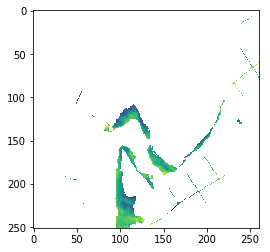

In [235]:
plt.imshow(log_AEM_interval)

In [228]:
log_AEM_interval

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)